In [55]:
import sys
sys.path.append('../')
from utils import *
import librosa
from librosa.display import waveplot
import pandas as pd
import numpy as np
import json
import os
import pdb

In [66]:
pre_max=10
post_max=10
pre_avg=10
post_avg=10
wait=10
delta=0.12
destFolder = f'TestPeak/{pre_max}_{post_max}_{pre_avg}_{post_avg}_{wait}_{delta}/'
os.makedirs(destFolder, exist_ok=True)

In [67]:
def plotEnergy(audio=None, sr=16000, audioPath=None, startTime=0, duration=None, ax=None, xticks=False, freqXlabels=5, annotate=False, cyclePath=None, numDiv=0, onsetPath=None, cAnnot=['purple'], annotLabel=True, winSize_odf=640, hopSize_odf=160, nFFT_odf=1024, source_odf='vocal', cOdf='black'):
	'''
	For debugging puposes only - plots energy function used to calculate odf

	Parameters:
		audio: loaded audio time series
		sr: sample rate that audio time series is loaded/ is to be loaded in
		audioPath: path to the audio file
		startTime: time to start reading the audio at
		duration: duration of audio to load
		ax: axis to plot waveplot in
		xticks: if True, will plot xticklabels
		freqXlabels: time (in seconds) after which each x label occurs
		annotate: if True, will annotate tala markings
		cyclePath: path to file with tala cycle annotations
		numDiv: number of divisions to put between each annotation marking
		onsetPath: path to file with onset annotations; only considered if cyclePath is None
		cAnnot: colour for the annotation marking
		annotLabel: if True, will print annotation label along with line; used only if annotate is True; used only if annotate is True
		odf: if True, will plot the onset detection function over the wave form
		winSize_odf: window size, fed to the onset detection function; valid only if odf is true
		hopSize_odf: hop size in seconds, fed to the onset detection function; valid only if odf is true
		nFFT_odf: size of DFT used in onset detection function; valid only if odf is true
		source_odf: type of instrument - vocal or pakhawaj, fed to odf; valid only if odf is true
		cOdf: colour to plot onset detection function in; valid only if odf is true
	'''
	if ax is None:
		Exception('ax parameter has to be provided')
	startTime = math.floor(startTime)   # set start time to an integer, for better readability on the x axis of the plot
	if audio is None:
		audio, sr = librosa.load(audioPath, sr=sr, offset=startTime, duration=duration)
		audio /= np.max(np.abs(audio))
	if duration is None:
		duration = librosa.get_duration(audio, sr=sr)
		duration = math.floor(duration)  # set duration to an integer, for better readability on the x axis of the plot
		audio = audio[:int(duration*sr)]    # ensure that audio length = duration
	ax.set(xlabel='' if not xticks else 'Time (s)', 
	xlim=(0, duration), 
	xticks=[] if not xticks else np.around(np.arange(0, duration, freqXlabels)),
	xticklabels=[] if not xticks else np.around(np.arange(startTime, duration+startTime, freqXlabels), 2),
	title='Energy Contour', 
	ylabel='dB')

	X,_ = librosa.magphase(librosa.stft(audio, win_length=winSize_odf, hop_length=hopSize_odf, n_fft=nFFT_odf))

	#use sub-band energy -> log transformation -> biphasic filtering, if vocal onset detection [1]
	if source_odf=='vocal':
		sub_band = [600,2400] #Hz
		energy = subBandEner(X, sr, sub_band)
		energy = toDB(energy, 100)

	#use spectral flux method (from FMP notebooks [2])
	elif source_odf=='perc':
		raise Exception('Not implemented')
	
	ax.plot(np.arange(0, duration, hopSize_odf/sr), energy[:-1], c=cOdf)
	if annotate:
		ax = drawAnnotation(cyclePath=cyclePath, onsetPath=onsetPath, numDiv=numDiv, startTime=startTime, duration=duration, ax=ax, cAnnot=cAnnot, annotLabel=annotLabel)
	return ax

In [68]:
def drawWave(audio=None, sr=16000, audioPath=None, startTime=0, duration=None, ax=None, xticks=False, yticks=True, xlabel=False, ylabel=True, title='Waveform', freqXlabels=5, annotate=False, odf=False, winSize_odf=640, hopSize_odf=160, nFFT_odf=1024, source_odf='vocal', cOdf='black', ylim=None, **kwargs): 
    '''Plots the wave plot of the audio

    Plots the waveform of the given audio using ``librosa.display.waveshow()``.

    Parameters
    ----------
        audio	: ndarray or None
            Loaded audio time series

        sr	: number > 0; default=16000
            If audio is not None, defines sample rate of audio time series 

            If audio is None and audioPath is not None, defines sample rate to load the audio at

        audioPath	: str, int, pathlib.Path, file-like object or None
            Path to the input file.

            Used only if audio is None. Audio is loaded as mono.

            Sent to ``librosa.load()`` as ``path`` parameter. 

            If None, ``audio`` cannot be None.

        startTime	: float; default=0
            Time stamp to consider audio from.

        duration	: float or None; default=None
            Duration of the audio to consider.

            If duration is None
                - If ``audio`` is None, duration is inferred from the audio.
                - If ``audio`` is None and ``audioPath`` is not None, the entire song is loaded.

        ax	: matplotlib.axes.Axes or None
            Axes to plot waveshow in.

            If None, will plot the object in ``plt.gca()``

        xticks	: bool
            If True, will add xticklabels to plot.

        yticks	: bool
            If True, will add yticklabels to plot.

        xlabel	: bool
            If True, will print xlabel in the plot.

        ylabel	: bool
            If True will print ylabel in the plot.

        title	: str
            Title to add to the plot.

        freqXlabels	: float > 0
            Time (in seconds) after which each x ticklabel occurs in the plot.

        annotate	: boolean
            If True, will annotate markings in either cyclePath or onsetPath with preference to cyclePath.

        odf	: bool
            If True, will plot the onset detection function over the wave form.

            Uses ``getODF()`` to compute ODF.

        winSize_odf    : int
            Window size (in frames) used by the onset detection function.

            If ``odf`` is True, passed to the ``getODF()`` function.

        hopSize_odf    : int
            Hop size (in frames) used by the onset detection function.

            If ``odf`` is True, passed to the ``getODF()`` function.

        nFFT_odf    : int
            Size of DFT used in onset detection function.

            If ``odf`` is True, passed to the ``getODF()`` function.

        source_odf	: str
            Defines type of instrument in the audio. Accepted values are:
            - 'vocal'
            - 'pakhawaj'

            Used in the ``getODF()`` only if ``odf`` is True.

        cOdf	: color 
            Colour to plot onset detection function in.

            If ``odf`` is True, passed to the ``getODF()`` function.

        ylim	: (float, float) or None
            (min, max) limits for the y axis.

            If None, will be directly interpreted from the data.

        kwargs	: Additional arguements passed to ``drawAnnotation()`` if ``annotate`` is True.

    Returns
    -------
        ax	: matplotlib.axes.Axes
            Waveform plot of given audio.

    '''

    if audio is None:
        audio, sr = librosa.load(audioPath, sr=sr, offset=startTime, duration=duration)
    if duration is None:
        duration = librosa.get_duration(audio, sr=sr)

    waveplot(audio, sr, ax=ax)

    if odf:
        plotODF(audio=audio, sr=sr, startTime=0, duration=None, ax=ax, winSize_odf=winSize_odf, hopSize_odf=hopSize_odf, nFFT_odf=nFFT_odf, source_odf=source_odf, cOdf=cOdf, ylim=True) 	# startTime=0 and duration=None because audio is already loaded.
        #Resolved #TODO-AskRohit: is plotODF required in other functions like pitch contour/spectrogram plots #

    # set ylim if required
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set(xlabel='' if not xlabel else 'Time (s)', 
    ylabel = '' if not ylabel else 'Amplitude',
    xlim=(0, duration), 
    xticks=[] if not xticks else np.around(np.arange(math.ceil(startTime) - startTime, duration, freqXlabels)),
    xticklabels=[] if not xticks else np.around(np.arange(math.ceil(startTime), duration+startTime, freqXlabels)).astype(int),
    yticks=[] if not yticks else np.around(np.linspace(min(audio), max(audio), 3), 1), 
    yticklabels=[] if not yticks else np.around(np.linspace(min(audio), max(audio), 3), 1), 
    ylim=ylim,
    title=title)

    if annotate:
        ax = drawAnnotation(startTime=startTime, duration=duration, ax=ax, **kwargs)

    return ax

In [69]:
def plotODF(audio=None, sr=16000, audioPath=None, odf=None, startTime=0, duration=None, ax=None, winSize_odf=640, hopSize_odf=160, nFFT_odf=1024, source_odf='vocal', cOdf='black', updatePlot=False, xlabel=False, ylabel=False, xticks=False, yticks=False, title='Onset Detection Function', freqXlabels=5, ylim=True, annotate=False, **kwargs):
	#Resolved #TODO-Rohit: added additional 'odf' parameter; in the spirit of separating our computation and plotting functions, this function should also ideally just plot odf, given odf as a parameter. But for now, I've added odf as a parameter and not removed audio input.
	'''
	Plots onset detection function if ``ax`` is provided. Function comes from ``getODF()``.
	
	If ``ax`` is None, function returns a tuple with 2 arrays - onset detection function values and time stamps

	Parameters
	----------
		audio	: ndarray or None
			Loaded audio time series

		sr	: number > 0; default=16000
			If audio is not None, defines sample rate of audio time series 

			If audio is None and audioPath is not None, defines sample rate to load the audio at

		audioPath	: str, int, pathlib.Path, file-like object or None
			Path to the input file.

			Used only if audio is None. Audio is loaded as mono.

			Sent to ``librosa.load()`` as ``path`` parameter. 

			If None, ``audio`` cannot be None.

		odf : ndarray
			Extracted onset detection function, if already available
			
			Can be obtained using ``getODF()`` function

		startTime	: float; default=0
			Time stamp to consider audio from.

		duration	: float or None; default=None
			Duration of the audio to consider.

			If ``duration`` is None
				- If ``audio`` is None, duration is inferred from the audio.
				- If ``audio`` is None and ``audioPath`` is not None, the entire song is loaded.

		ax	: matplotlib.axes.Axes
			Axes object to plot waveshow in.

		winSize_odf    : int
			Window size (in frames) used by the onset detection function.

			If ``odf`` is True, passed to the ``getODF()`` function.

		hopSize_odf    : int
			Hop size (in frames) used by the onset detection function.

			If ``odf`` is True, passed to the ``getODF()`` function.

		nFFT_odf    : int
			Size of DFT used in onset detection function.

			If ``odf`` is True, passed to the ``getODF()`` function.

		source_odf	: str
			Defines type of instrument in the audio. Accepted values are:
			- 'vocal'
			- 'pakhawaj'
			
			Used in the ``getODF()`` only if ``odf`` is True.

		cOdf	: color 
			Colour to plot onset detection function in.

			If ``odf`` is True, passed to the ``getOnsetActivation()`` function.

		updatePlot  : bool
			If odf being plotting on figure with waveform, then retain axis labels and properties

		xticks	: bool
			If True, will add xticklabels to plot.

		yticks	: bool
			If True, will add yticklabels to plot.

		xlabel	: bool
			If True, will print xlabel in the plot.

		ylabel	: bool
			If True will print ylabel in the plot.

		title	: str
			Title to add to the plot.

		freqXlabels	: float > 0
			Time (in seconds) after which each x ticklabel occurs in the plot.

		ylim	: (float, float) or None
			(min, max) limits for the y axis.
			
			If None, will be directly interpreted from the data.

		annotate	: boolean
			If True, will annotate markings in either cyclePath or onsetPath with preference to cyclePath.

		kwargs	: Additional arguements passed to ``drawAnnotation()`` if ``annotate`` is True.

	Returns
	-------
		ax	: matplotlib.axes.Axes)
			If ``ax`` is not None, returns a plot
		
		(odf_vals, time_vals): (ndarray, ndarray)
			If ``ax`` is None, returns a tuple with ODF values and time stamps.
	'''

	if odf is None:

		if audio is None:
			audio, sr = librosa.load(audioPath, sr=sr, offset=startTime, duration=duration)
		if duration is None:
			duration = librosa.get_duration(audio, sr=sr)
		
		odf_vals, _ = getODF(audio=audio, audioPath=None, startTime=startTime, duration=duration, fs=sr, winSize=winSize_odf, hopSize=hopSize_odf, nFFT=nFFT_odf, source=source_odf)

	else:
		odf_vals = odf.copy()
		duration = len(odf_vals)*hopSize_odf/sr
	
	# set time and odf values in variables
	time_vals = np.arange(startTime, startTime+duration, hopSize_odf/sr)
	#Resolved #TODO-Rohit: changed last argument to hopsize_odf/sr because hopsize_odf is in frames now 
	
	#Resolved # TODO-Rohit: not sure above line is necessary. I got length mismatch errors so commented it. We could instead add code to make lengths same like below:
	odf_vals = odf_vals[: min((len(time_vals), len(time_vals)))]
	time_vals = time_vals[: min((len(time_vals), len(time_vals)))]


	if ax is None:
		# if ax is None, return (odf_vals, time_vals)
		return (odf_vals, time_vals)
	else:
		#Resolved #TODO-Rohit added below 'if updatePlot' block to retain existing ax properties in case odf is being plotted on top of waveform. Can add this block in other plotting functions too
		if updatePlot:
			xticks_, yticks_, xticklabels_, yticklabels_, title_, xlabel_, ylabel_ = ax.get_xticks(), ax.get_yticks(), ax.get_xticklabels(), ax.get_yticklabels(), ax.get_title(), ax.get_xlabel(), ax.get_ylabel()
		else:
			xticks_, yticks_, xticklabels_, yticklabels_, title_, xlabel_, ylabel_ = [],[],[],[],title,'',''

		ax.plot(time_vals, odf_vals, c=cOdf)     # plot odf_vals and consider odf_vals for all values except the last frame
		max_abs_val = max(abs(odf_vals))   # find maximum value to set y limits to ensure symmetrical plot
		# set ax parameters only if they are not None
		ax.set(xlabel=xlabel_ if not xlabel else 'Time (s)', 
		ylabel = ylabel_ if not ylabel else 'ODF',
		xlim=(0, duration), 
		xticks=xticks_ if not xticks else np.around(np.arange(math.ceil(startTime), duration+startTime, freqXlabels)),
		xticklabels=xticklabels_ if not xticks else np.around(np.arange(math.ceil(startTime), duration+startTime, freqXlabels)).astype(int),
		yticks=yticks_ if not yticks else np.around(np.linspace(-max_abs_val,max_abs_val, 3), 2), #Resolved #TODO-Rohit linspace args edited from min & max(audio)
		yticklabels=yticklabels_ if not yticks else np.around(np.linspace(-max_abs_val,max_abs_val, 3), 2), #Resolved #TODO-Rohit linspace args edited from min & max(audio) - AskRohit: shouldn't the first and second arguement also be -max_abs_val and max_abs_val (like int the previous line) since these are the corresponding label values for the ticks marked in the previous line.
		ylim= ax.get_ylim() if ylim is not None else (-max_abs_val, max_abs_val),
		title=title_) #Resolved #TODO- AskRohit: should the title parameter be removed from this function if it isn't being used?

		# Added by Nithya to add annotations to the plot
		if annotate:
			ax = drawAnnotation(startTime=startTime, duration=duration, ax=ax, **kwargs)
		return ax

In [70]:
def getODF(audio=None, audioPath=None, startTime=0, duration=None, fs=16000, winSize=640, hopSize=160, nFFT=1024, source='vocal'):
    '''Computes onset activation function from audio signal using short-time spectrum based methods.

Parameters
----------
    audio   : ndarray
        Audio signal
    audioPath  : str
        Path to the audio file
    startTime   : int or float
        Time to start reading the audio at
    duration    : int or float
        Duration of audio to read
    fs  : int or float
        Sampling rate to read audio at
    winSize : int
        Window size (in samples) for STFT
    hopSize : int
        Hop size (in samples) for STFT
    nFFT    : int
        DFT size
    source  : str
        Source instrument in audio - one of 'vocal' or 'perc' (percussion)

Returns
----------
    odf : ndarray
        Frame-wise onset activation function (at a sampling rate of 1/hopSize)
    onsets  ndarray
        Time locations of detected onset peaks in the odf (peaks detected using peak picker from librosa)
'''
    #if audio signal is provided
    if audio is not None:
        #select segment of interest from audio based on start time and duration
        if duration is None:
            audio = audio[int(np.ceil(startTime*fs)):]
        else:
            audio = audio[int(np.ceil(startTime*fs)):int(np.ceil((startTime+duration)*fs))]

    #if audio path is provided
    elif audioPath is not None:
        audio,_ = librosa.load(audioPath, sr=fs, offset=startTime, duration=duration)

    else:
        print('Provide either the audio signal or path to the stored audio file on disk')
        raise

    #fade in and out ends of audio to prevent spurious onsets due to abrupt start and end
    audio = fadeIn(audio,int(0.5*fs))
    audio = fadeOut(audio,int(0.5*fs))

    #compute magnitude STFT
    X,_ = librosa.magphase(librosa.stft(audio, win_length=winSize, hop_length=hopSize, n_fft=nFFT))

    #use sub-band energy -> log transformation -> biphasic filtering, if vocal onset detection [1]
    if source=='vocal':
        sub_band = [600,2400] #Hz
        odf = subBandEner(X, fs, sub_band)
        odf = toDB(odf, 100)
        odf = biphasicDerivative(odf, hopSize/fs, norm=True, rectify=True)

        #get onset locations using librosa's peak-picking function
        onsets = librosa.onset.onset_detect(onset_envelope=odf.copy(), sr=fs, hop_length=hopSize, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, wait=wait, delta=delta)*hopSize/fs

    #use spectral flux method (from FMP notebooks [2])
    elif source=='perc':
        sub_band = [0,fs/2] #full band
        odf = fmp.spectral_flux(audio, Fs=fs, N=nFFT, W=winSize, H=hopSize, M=20, band=sub_band)
        onsets = librosa.onset.onset_detect(onset_envelope=odf, sr=fs, hop_length=hopSize, pre_max=1, post_max=1, pre_avg=1, post_avg=1, wait=10, delta=0.05)*hopSize/fs

    return odf, onsets

### Score DataFrame

In [71]:
def evaluate_peaks(target_time, predict_time, predict_confidence, delta=0.025):
    # pdb.set_trace()
    precision = 0
    precision_conf = 0
    for i, pt in enumerate(predict_time):
        if len(np.where(np.logical_and(target_time > pt - delta, target_time < pt + delta))[0]) > 0:
            precision += 1
            precision_conf += predict_confidence[i]
    precision /= len(predict_time)
    precision_conf /= len(predict_time)
    
    recall = 0
    recall_conf = 0
    for tt in target_time:
        results = np.where(np.logical_and(predict_time > tt - delta, predict_time < tt + delta))[0]
        if len(results) > 0:
            recall += 1
            recall_conf += np.mean(predict_confidence[results])
    recall /= len(target_time)
    recall_conf /= len(target_time)
    
    return precision, precision_conf, recall, recall_conf

In [72]:
def getPeaks(audioPath=None, sr=16000, winSize=640, hopSize=160, nFFT=1024, source='vocal'):
    odf, onsets = getODF(audioPath=audioPath, 
                  winSize=winSize,
                  hopSize=hopSize, 
                  nFFT=nFFT, 
                  source=source)
    peak_df = pd.DataFrame({'peak instant': onsets, 'peak height': odf[(onsets*(sr/hopSize)).astype('int')]})
    return peak_df

In [76]:
def generatePlot(metadata, peak_df):
    fig, axs = generateFig(4, (28, 10), [4, 5, 3, 4])
    # plot waveplot
    axs[0] = drawWave(audioPath=metadata['vocal_audio_path'], 
                      ax=axs[0], 
                      annotate=True, 
                      onsetPath=metadata['onset_file'], 
                      odf=True,
                      winSize_odf=640,
                      hopSize_odf=160, 
                      nFFT_odf=1024, 
                      source_odf='vocal')

    # plot peaks
    for _, row in peak_df.iterrows():
        axs[0].axvline(row['peak instant'], ymin=0, 
                 ymax=(row['peak height']/max(peak_df['peak height'])), c='red', linestyle='--')

    # plot pitch contour
    axs[1] = pitchContour(audioPath=metadata['vocal_audio_path'], 
                           minPitch=metadata['min_pitch'], 
                           maxPitch=metadata['max_pitch'], 
                           notes=metadata['notes'], 
                           tonic=metadata['tonic'], 
                           ax=axs[1], 
                           annotate=True, 
                           annotLabel=False, 
                           onsetPath=metadata['onset_file'])
    # plot spetogram 2
    axs[2] = spectrogram(audioPath=metadata['vocal_audio_path'], 
                         cmap='Blues', 
                         ax=axs[2], 
                         annotate=True, 
                         annotLabel=False,
                         onsetPath=metadata['onset_file'])
    # plot energy contour
    axs[3] = plotEnergy(audioPath=metadata['vocal_audio_path'], 
                        ax=axs[3], 
                        annotate=True, 
                        onsetPath=metadata['onset_file'], 
                        annotLabel=False,
                        xticks=True, 
                        freqXlabels=1)
    
    fig.savefig(destFolder + metadata['vocal_audio_path'].rsplit('/', 1)[1].rsplit('-', 1)[0] + '.png')

In [77]:
def parse_files(audioFolder, destFolder):
    score_data = []
    for root, _, fileList in os.walk(audioFolder):
        for file in fileList:
            print(file)
            if 'TilakK' in file:
                f = open('Data/metadata-TilakK.json', 'r')
            else:
                f = open('Data/metadata-RagBah.json', 'r')
            metadata = json.load(f)
            metadata['vocal_audio_path'] = os.path.join(root, file)
            metadata['onset_file'] = os.path.join(root, file).replace('SSAudio', 'Annotations').replace('-SS.wav', '.csv')
            print(metadata)
            
            target_times = pd.read_csv(metadata['onset_file'])['Inst'].values
            peak_df = getPeaks(audioPath = metadata['vocal_audio_path'])
            predicted_times = peak_df['peak instant'].values
            predicted_conf = peak_df['peak height'].values
            p, pc, r, rc = evaluate_peaks(target_times, predicted_times, predicted_conf)
            print(target_times,  predicted_times)
            score_data.append([metadata['vocal_audio_path'].rsplit('/', 1)[1], p, pc, r, rc])
                
            generatePlot(metadata, peak_df)
            
            peak_df.to_csv(destFolder + metadata['vocal_audio_path'].rsplit('/', 1)[1].replace('-SS.wav', '.csv'), index=False)
    
    score_data.append(['Mean', np.mean([d[1] for d in score_data]), 
                       np.mean([d[2] for d in score_data]), 
                       np.mean([d[3] for d in score_data]), 
                       np.mean([d[4] for d in score_data])])
    pd.DataFrame(score_data, columns=['File Name', 'Precision', 'Precision Confidence', 'Recall', 'Recall Confidence']).to_csv(destFolder + 'results.csv', index=False)

NIRP1_MAK_TilakK_Vox_1-SS.wav
{'min_pitch': 138.59, 'max_pitch': 622.25, 'start_time': 0, 'duration': None, 'vocal_audio_path': 'Data/OSF/SSAudio/NIRP1_MAK_TilakK_Vox_1-SS.wav', 'onset_file': 'Data/OSF/Annotations/NIRP1_MAK_TilakK_Vox_1.csv', 'tonic': 209.32, 'notes': [{'label': 'P_', 'cents': -500}, {'label': 'D_', 'cents': -300}, {'label': 'N_', 'cents': -100}, {'label': 'S', 'cents': 0}, {'label': 'R', 'cents': 200}, {'label': 'G', 'cents': 400}, {'label': 'm', 'cents': 500}, {'label': 'P', 'cents': 700}, {'label': 'D', 'cents': 900}, {'label': 'N', 'cents': 1100}, {'label': "S'", 'cents': 1200}, {'label': "R'", 'cents': 1400}, {'label': "G'", 'cents': 1600}, {'label': "m'", 'cents': 1700}, {'label': "P'", 'cents': 1900}]}
[ 0.29        0.89333333  1.70666667  3.70333333  5.25666667  5.69666667
  7.31666667  8.283      10.23       11.49935417 12.723      14.016
 16.869      17.295      19.812      21.912      23.124      23.958
 24.789      25.674      26.841      27.261      28.829

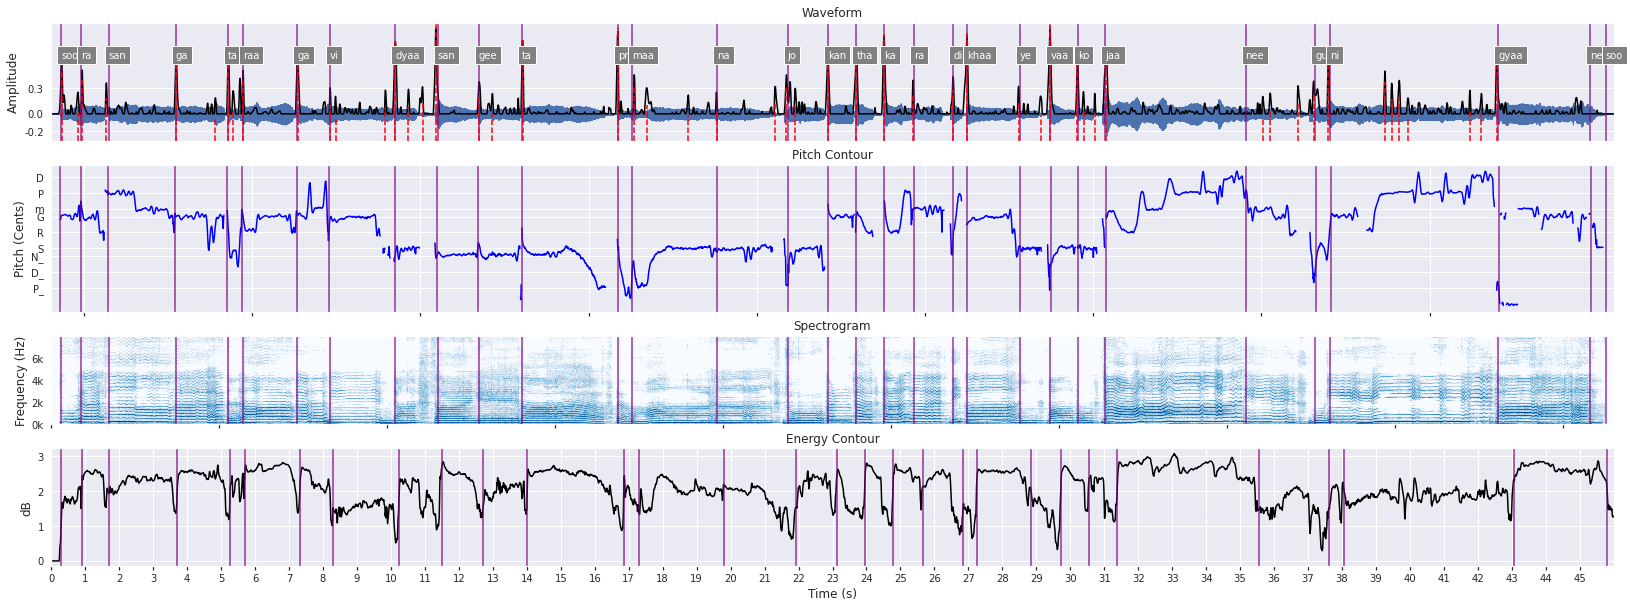

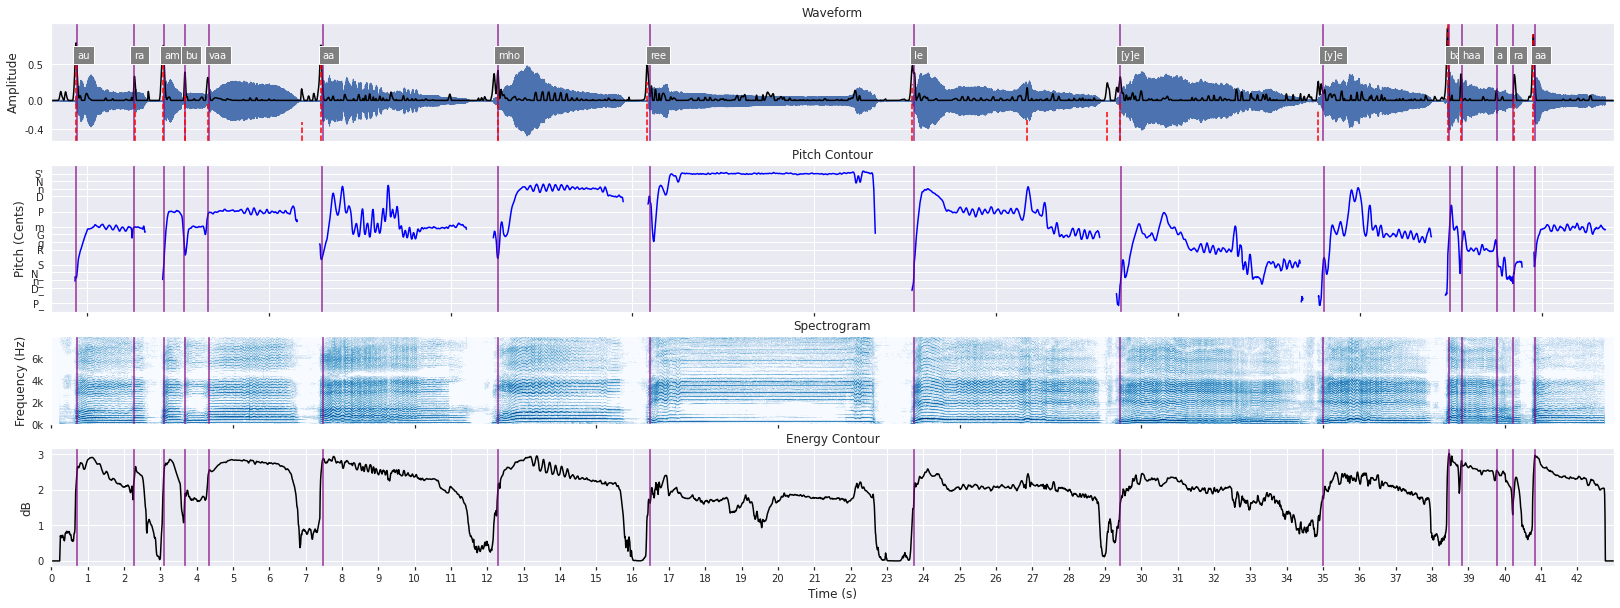

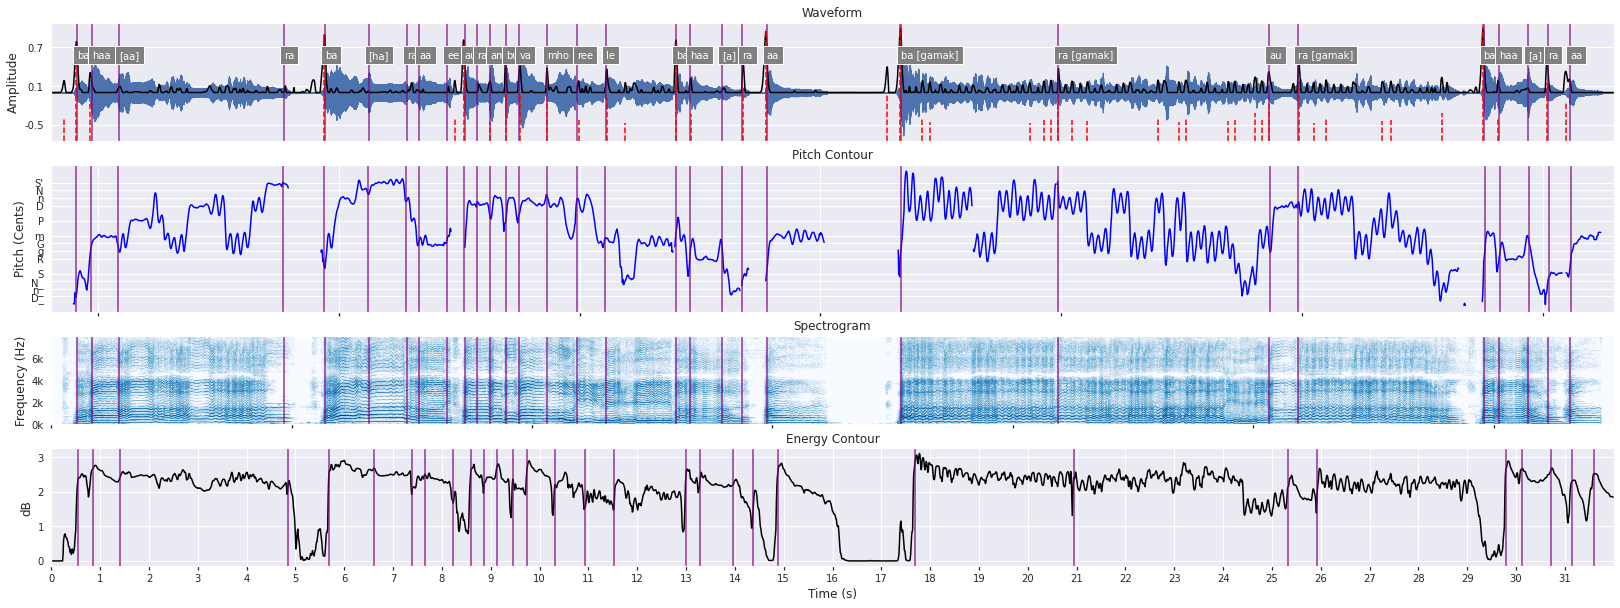

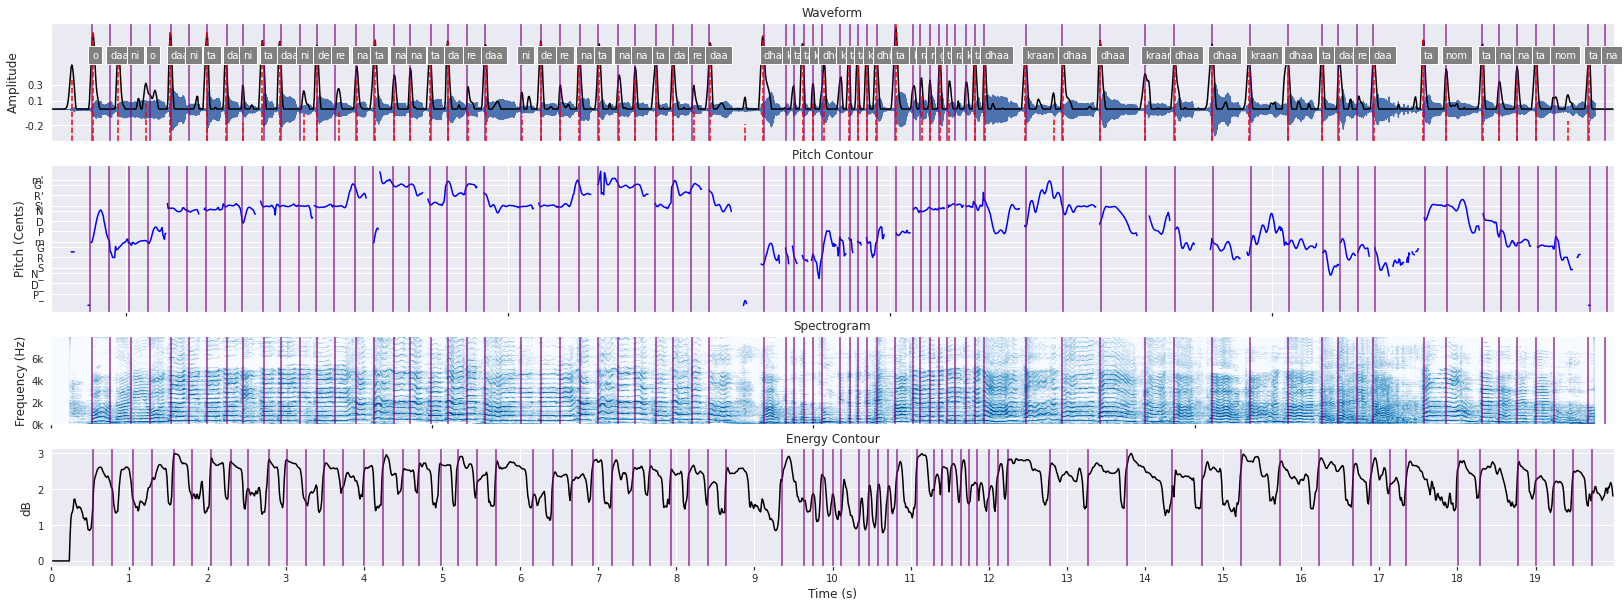

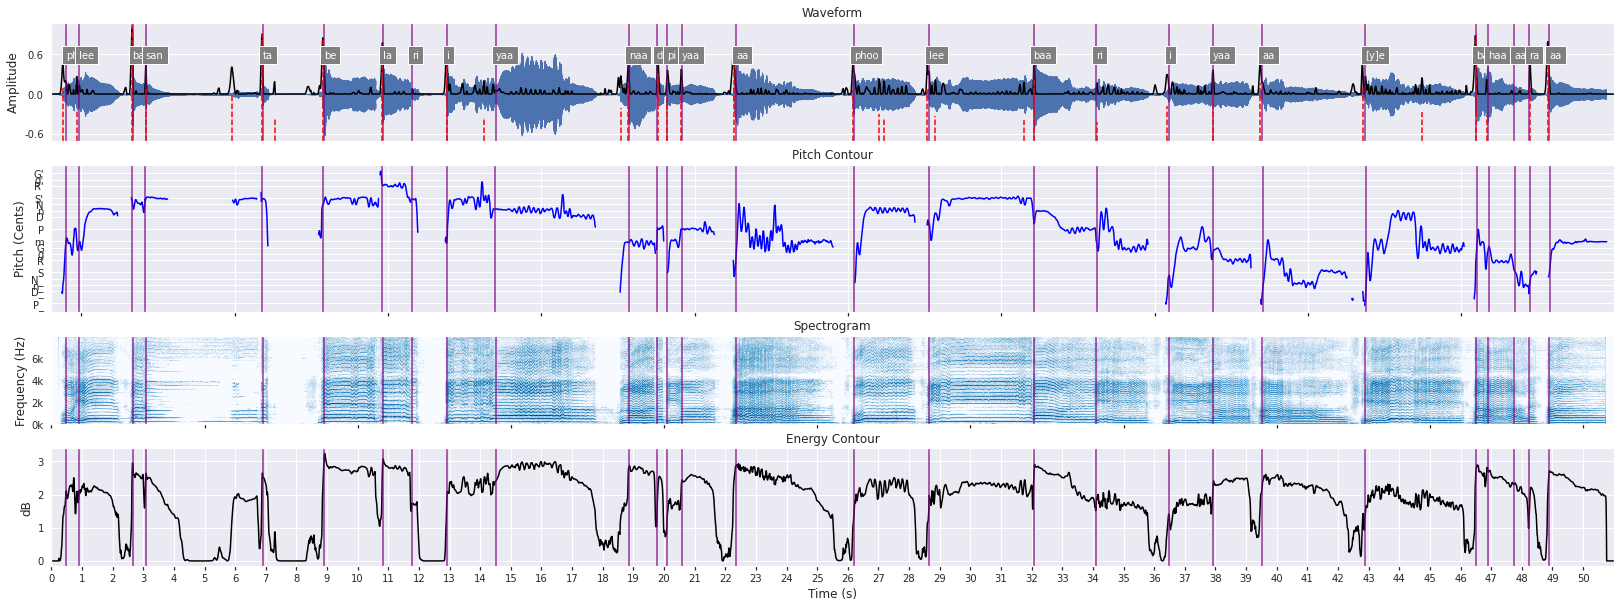

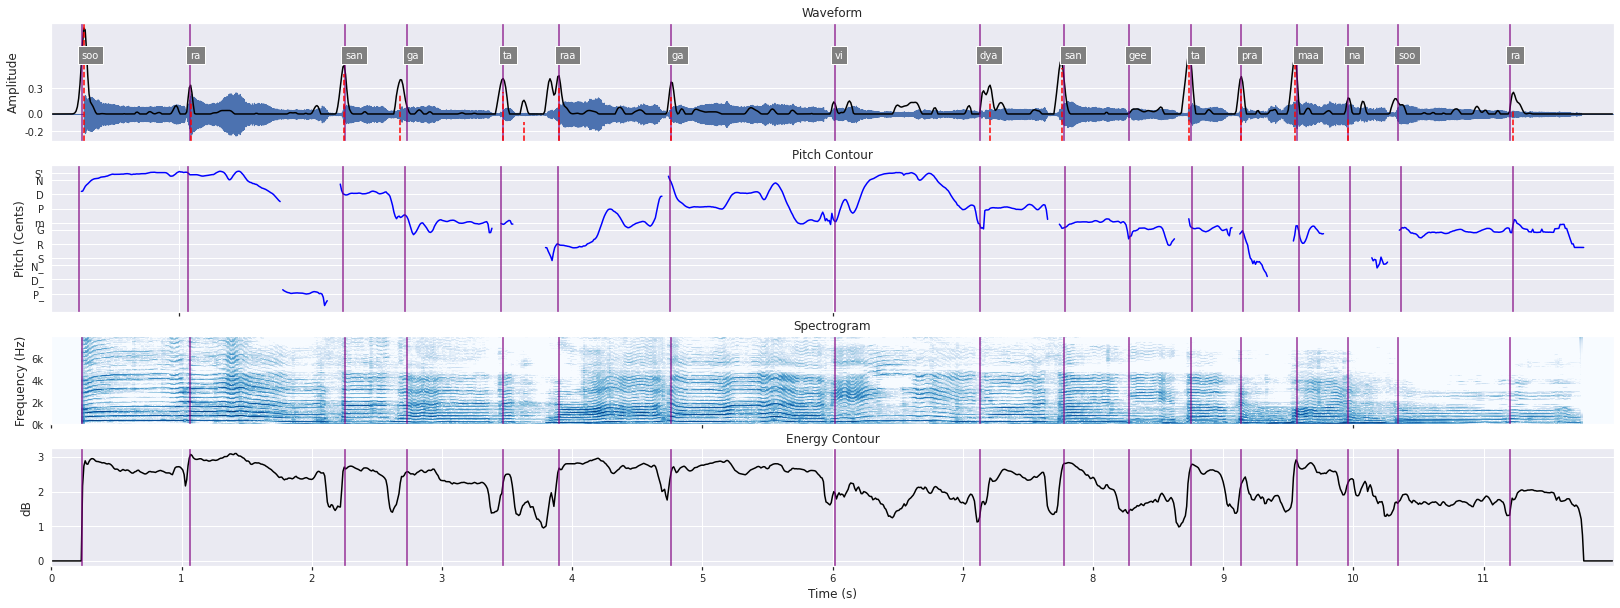

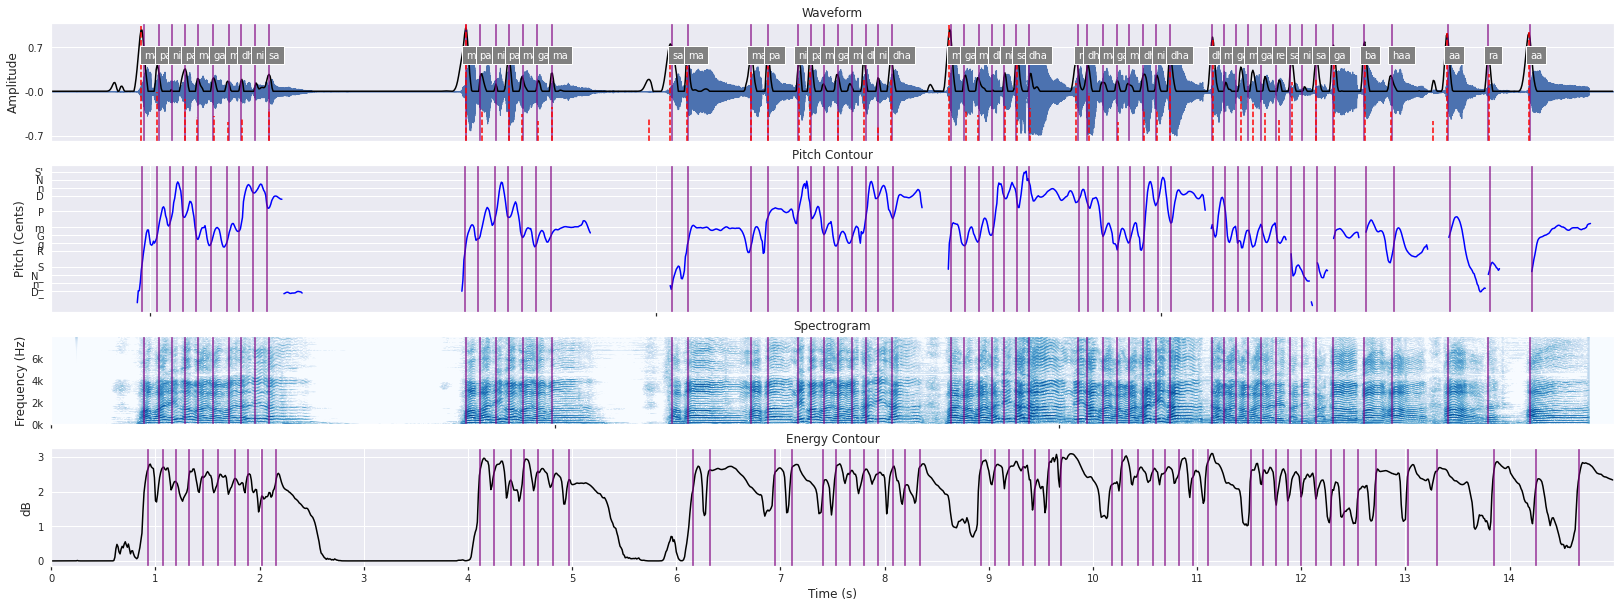

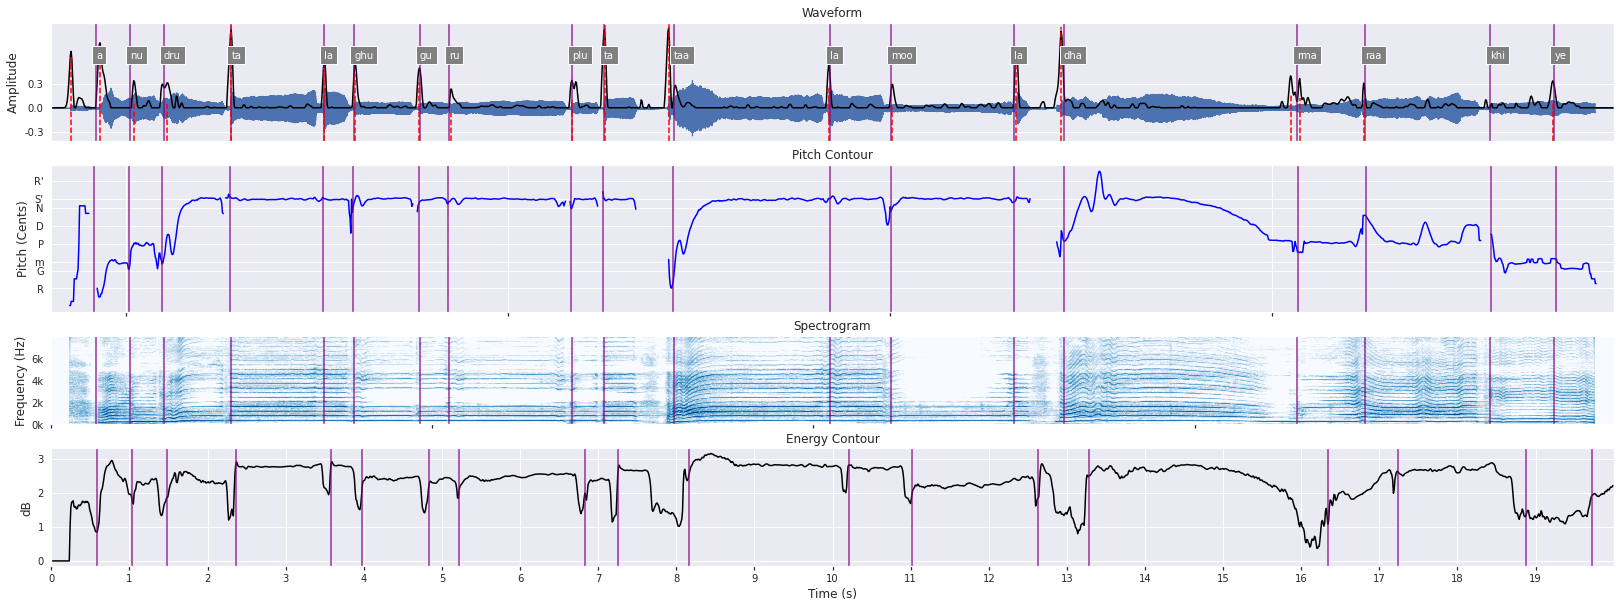

In [78]:
parse_files('Data/OSF/SSAudio/', destFolder)